In [312]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.nn import functional as F
from torch import topk
import torch
import numpy as np
import skimage.transform

## Load Model

In [313]:
ResNet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

In [314]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
ResNet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Load Image

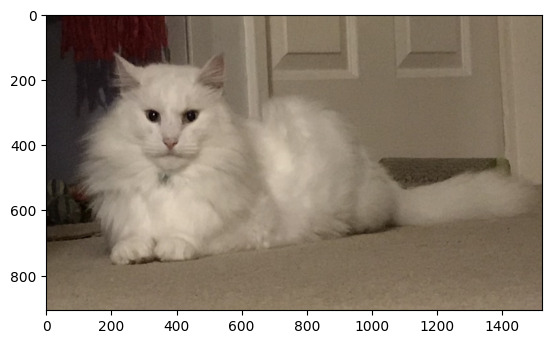

In [315]:
image = Image.open("casper2.jpg")
imshow(image)

In [316]:
img_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

tensor = img_transforms(image)
prediction_var = tensor.unsqueeze(0).to(device).requires_grad_()

## Hook

In [317]:
class SaveFeatures:
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()

In [318]:
final_layer = ResNet._modules.get('layer4')
activated_features = SaveFeatures(final_layer)

In [319]:
prediction = ResNet(prediction_var)
pred_probabilities = F.softmax(prediction, dim=1).data.squeeze()

In [320]:
activated_features.remove()

## CAM

In [321]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]  

In [322]:
weigth_softmax_params = list(ResNet._modules.get('fc').parameters())
weight_softmax = np.squeeze(weigth_softmax_params[0].cpu().data.numpy())

In [323]:
class_idx = topk(pred_probabilities,1)[1].int()


## Get CAM

In [324]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

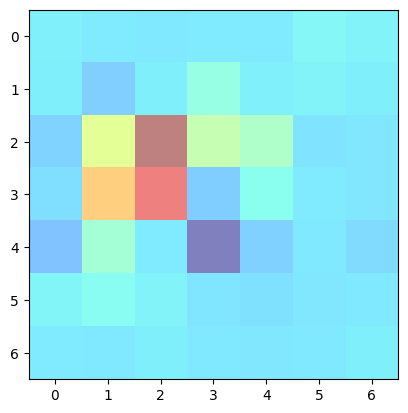

In [325]:
imshow(overlay[0], alpha=0.5, cmap='jet')

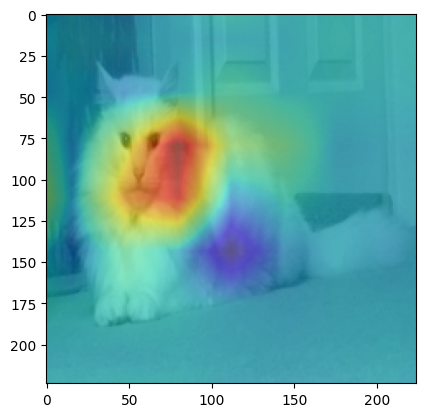

In [326]:
display_transform = transforms.Compose([
    transforms.Resize((224,224)),
])

imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet')